In [1]:
from netgen.geom2d import CSG2d, Circle, Rectangle
from ngsolve import *
import ngsolve
import numpy as np
import scipy

In [4]:
class Anneau:
    """Initialise la géométrie d'un anneau (cercle_ext-cercle_int)"""
    def __init__(self, r_int : float, r_ext : float):
        """
        Initialise l'anneau
                
        Paramètres
        ----------
        r_int : float
            rayon du cercle intérieur
        r_ext : float  
            rayon du cercle extérieur
        """
        self.r_int = r_int
        self.r_ext = r_ext
        if r_ext< r_int or r_int<=0 or r_ext <=0:
            raise ValueError
        geo = CSG2d()
        self.label_ext = 'bc_circle_ext'
        """
        Attribut 
        ----------
        label_ext : str
            label du cercle extérieur
        """
        self.label_int = 'bc_circle_int'
        """
        Attribut 
        ----------
        label_int : str
            label du cercle intérieur
        """
        #square = Rectangle(pmin = (-1,-1),pmax = (1,1),bc = "bc_rect")
        cercle_ext = Circle(center = (0,0), radius = self.r_ext, bc = self.label_ext)
        circle_int = Circle(center = (0,0), radius = self.r_int, bc = self.label_int)
        domain = cercle_ext-circle_int
        geo.Add(domain)
        self.geo = geo
        """
        Attribut
        ---------
        geo : Géométrie
        """

In [5]:
class Square:
    """Représente la géométrie d'un carré en extérieur et cercle en intérieur"""
    def __init__(self, r_int : float, pmin : tuple[float], pmax : tuple[float]):
        """
        Initialisation de la géométrie

        Paramètres
        -----------
        r_int : float
            rayon du cercle intérieur
        pmin : tuple[float]
            point en bas à gauche du carré
        pmax : tuple[float]
            point en haut à droite du carré
        """
        self.r_int = r_int
        self.pmin = pmin
        self.pmax = pmax
        if r_int<=0 or pmin> pmax:
            raise ValueError
        self.label_ext = 'bc_rect'
        """
        Attribut 
        ----------
        label_ext : str
            label du carré
        """
        self.label_int = 'bc_circle'
        """
        Attribut 
        ----------
        label_int : str
            label du cercle intérieur
        """
        geo = CSG2d()
        rectangle = Rectangle(pmin = self.pmin,pmax = self.pmax,bc = self.label_ext)
        circle_int = Circle(center = (0,0), radius = 0.5, bc = self.label_int)
        domain = rectangle-circle_int
        geo.Add(domain)
        self.geo = geo
        """
        Attribut
        ---------
        geo : Géométrie
        """

In [6]:
class Demi_disque:
    """
    Permet de créer un demi-cercle avec un petit cercle à l'intérieur
    """
    def __init__(self,centre_demi : tuple[float], r_demi : float, r_int : float, pmin : tuple[float], pmax : tuple[float]):
        """
        Initialisation de la géométrie

        Paramètres
        -----------
        centre_demi : tuple[float]
            centre du demi-cercle
        r_demi : float
            rayon du demi-cercle
        r_int : float
            rayon du cercle intérieur
        pmin : tuple[float]
            point en bas à gauche du carré
        pmax : tuple[float]
            point en haut à droite du carré
        """
        self.centre_demi = centre_demi
        self.r_demi = r_demi
        self.r_int = r_int
        self.pmin = pmin
        self.pmax = pmax
        geo = CSG2d()
        circle1 = Circle(center = self.centre_demi, radius = self.r_demi,bc = "bc_circle1")
        circle2 = Circle(center = (0,0), radius = self.r_int, bc = "bc_circle2")
        rect = Rectangle(pmin =self.pmin, pmax = self.pmax, bc = "bc_rect")
        self.label_int = "bc_circle2"
        """
        Attribut
        ----------
        label_int : str
            label du demi-cercle
        """
        self.label_ext = "bc_circle1|bc_rect"
        """
        Attribut
        ----------
        label_ext : str
            label du cercle extérieur
        """
        domain = circle1-circle2 - rect
        geo.Add(domain)
        self.geo = geo
        """
        Attribut
        ---------
        geo : Géométrie
        """


In [7]:
class Maillage:
    """Représente un maillage"""
    def __init__(self, maxh : float, espace : Anneau|Square|Demi_disque):
        """initialise un mesh 
        
        Paramètres:
        ----------
        maxh : float
            taille maximum du maillage
        espace : Anneau|Square|Demi-Disque
            Geometrie de l'espace
        
        """
        self.maxh = maxh
        self.espace = espace
        m = espace.geo.GenerateMesh(maxh = self.maxh)
        mesh = Mesh(m)
        self.mesh = mesh
        """
        Attribut
        ---------
        mesh : maillage de l'anneau
        """ 

        
    def inner_H1(self,u : GridFunction,v : GridFunction) -> float :
        """
        Permet de calculer le produit scalaire H¹

        Paramètres:
        ----------
        u, v : Gridfunction

        Sortie
        -------
        float : produit scalaire H¹ de u et v
        """
        fes = H1(self.mesh, order = 1)
        u_H1,v_H1 = fes.TnT()
        a = BilinearForm(grad(u_H1)*grad(v_H1)*dx + u_H1*v_H1*dx).Assemble()
        return InnerProduct(u.vec,a.mat*v.vec)

    def norme_H1_carre(self,u : GridFunction) -> float:
        """
        Permet de calculer la norme H¹ au carré

        Paramètres
        ----------
        u : Grifunction

        Sortie
        --------
        float : norme H¹ au carré de u
        """
        return self.inner_H1(u,u)
    
    def inner_H1_0(self,u : GridFunction,v : GridFunction) -> float:
        """
        Permet de calculer le produit scalaire H¹₀

        Paramètres:
        ----------
        u, v : Gridfunction

        Sortie
        -------
        float : produit scalaire H¹₀ de u et v
        """
        str_bords = self.espace.label_ext + '|' + self.espace.label_int
        fes = H1(self.mesh, order = 1, dirichlet = str_bords)
        u_H1_0,v_H1_0 = fes.TnT()
        a = BilinearForm(grad(u_H1_0)*grad(v_H1_0)*dx).Assemble()
        return InnerProduct(u.vec,a.mat*v.vec)

    def norme_H1_0_carre(self,u : GridFunction) -> float:
        """
        Permet de calculer la norme H¹₀ au carré

        Paramètres
        ----------
        u : Grifunction

        Sortie
        --------
        float : norme H¹₀ au carré de u
        """
        return self.inner_H1_0(u,u)

    def inner_L2(self, u : GridFunction, v : GridFunction) -> float :
        """
        Permet de calculer le produit scalaire L2

        Paramètres
        -----------
        u: GridFunction
        v : GridFunction

        Sortie
        -------
        float : produit scalire L2 entre u et v
        """
        fes = L2(self.mesh, order = 1)
        u_L2, v_L2 = fes.TnT()
        a = BilinearForm(u_L2*v_L2*dx).Assemble()
        return InnerProduct(u.vec, a.mat*v.vec)
    
    def norme_L2_carre(self, u : GridFunction) -> float:
        """
        Permet de calculer la norme L2 au carré

        Paramètres
        ----------
        u: GridFunction

        Sortie
        -------
        float : norme L2 carré de u
        """
        return self.inner_L2(u,u)
    
    def discret_to_grid(self,tab : np.ndarray, flag : bool) -> GridFunction:
        """
        Transforme un array (tab) en une fonction continue sur l'espace fs

        Paramètres
        ----------
        tab : np.ndarray
            fonction discretisée sur l'espace H1

        Sortie
        -------
        GridFunction : tab transformée en GridFunction sur fs

        Error
        -------
        IndexError : si la taille du tableau ne correspond pas au mesh utilisé pour définir fs
        """
        if flag == True:
            fes = H1(self.mesh, order = 1)
        else:
            fes = L2(self.mesh, order = 1)
        gf = GridFunction(fes)
        if not gf.vec.size == len(tab):
            raise IndexError
        gf.vec[:] = tab
        return gf 
    
    def get_neighbor(self,v1 : NodeId ,v2 : NodeId) -> int:
        """
        Permet de trouver le troisième sommet d'un triangle

        Paramètres
        -----------
        v1 : Vertices
            sommet sur le bord du maillage
        v2 : vertices
            sommet sur le bord du maillage
        
        Sortie
        int : nombre du troisième sommet du triangle (unique car nous sommes sur le bord)
        """
        for el in self.mesh.Elements(VOL):
            v = el.vertices
            if v1 == v[0] :
                if v2 == v[1]:
                    return v[2].nr
                elif v2 == v[2]:
                    return v[1].nr
            elif v1 == v[1] :
                if v2 == v[0]:
                    return v[2].nr
                elif v2 == v[2]:
                    return v[0].nr
            elif v1 == v[2]:
                if v2 == v[0]:
                    return v[1].nr
                elif v2 == v[1]:
                    return v[0].nr


    def vec_dir_norm(self, point0 : tuple[float],point1 : tuple[float])->list[float]:
        """
        Permet de trouver le vecteur directeur normalisé entre deux points

        Paramètres
        ----------
        point0 : tuple[float]
        point1 : tuple[float]

        Sortie
        ---------
        list[float] : vecteur directeur normalisé
        """
        diff = [point1[0]-point0[0],point1[1]-point0[1]]
        s = sqrt(diff[0]**2+diff[1]**2)
        return [diff[0]/s, diff[1]/s]

    def vec_dir(self, point0 : tuple[float],point1 : tuple[float])->list[float]:
        """
        Permet de trouver le vecteur directeur entre deux points

        Paramètres
        ----------
        point0 : tuple[float]
        point1 : tuple[float]

        Sortie
        ---------
        list[float] : vecteur directeur
        """
        diff = [point1[0]-point0[0],point1[1]-point0[1]]
        return diff

    def produit_scalaire(self, list_v1 : list[float], list_v2 : list[float])-> float:
        """
        Permet de calculer le produit scalaire entre deux vecteurs

        Paramètres
        ----------
        list_v1 : list[float]
        list_v2 : list[float]

        Sortie
        -------
        float : produit scalaire entre list_v1 et list_v2
        """
        return list_v1[0]*list_v2[0]+list_v1[1]*list_v2[1]
    
    def get_derive_normal(self) -> list:
        """
        Paramètres
        ---------
        None

        Sortie
        -------
        list : dérivée normale, minimum, maximum
        """
        phi = self.get_sol_elec()
        res = []
        min_r = 1e150
        max_r = 0
        for el in self.mesh.Elements(BND):
            if el.mat == self.espace.label_int:
                nr0 = el.vertices[0].nr
                nr1 = el.vertices[1].nr
                nr2 = self.get_neighbor(el.vertices[0],el.vertices[1])
                point0 = self.mesh.vertices[nr0].point
                point1 = self.mesh.vertices[nr1].point
                point2 = self.mesh.vertices[nr2].point
                t2 = self.vec_dir_norm(point0,point1)
                n = [-t2[1],t2[0]]
                t1 = self.vec_dir(point1,point2)
                t1_norm = sqrt(t1[0]**2+t1[1]**2)
                p1_phi = (phi.vec[nr2]-1)/t1_norm
                t1 = self.vec_dir_norm(point1,point2)
                n_t1 = self.produit_scalaire(t1, n)
                t1_t2 = self.produit_scalaire(t1, t2)
                res.append(abs(p1_phi*n_t1/(1-t1_t2**2)))
                if min_r > abs(p1_phi*n_t1/(1-t1_t2**2)):
                    min_r = abs(p1_phi*n_t1/(1-t1_t2**2))
                elif max_r < abs(p1_phi*n_t1/(1-t1_t2**2)):
                    max_r = abs(p1_phi*n_t1/(1-t1_t2**2))
        return res, min_r, max_r

    def get_sol_elec(self) -> GridFunction:
        """
        Permet d'obtenir la solution électrostatique

        Paramètre
        ----------
        None
        
        Sortie
        --------
        GridFunction: solution électrostatique
        """
        str_bords = self.espace.label_ext + '|' + self.espace.label_int
        fes = H1(self.mesh,order = 1, dirichlet =str_bords)
        g = self.mesh.BoundaryCF({self.espace.label_ext:0, self.espace.label_int:1}, default = 0)
        gfu = GridFunction(fes)
        gfu.Set(g,BND)
        u,v = fes.TnT()
        a = BilinearForm(grad(u)*grad(v)*dx).Assemble()
        f = LinearForm(v*dx).Assemble()
        c= Preconditioner(a, "local")
        c.Update()
        solvers.BVP(bf = a, lf = f, gf = gfu, pre = c, print = False)
        return gfu 

In [8]:
class Problem_2D:
    """
    Représente une instance du problème en 2D
    On résout dans H^1
    """
    def __init__(self, maillage : Maillage, A : GridFunction):
        """
        Initialise les paramètres nécessaires au problème 2D

        Paramètres:
        ------------
        maillage : Maillage
            maillage de l'espace sur lequel on veut trouver les solutions
        A : GridFunction
            Condition de Neumann (peut être constante)
        """
        self.maillage = maillage
        self.A = A        
    
    def is_lower(self) -> bool:
        """
        Permet de savoir si la condition de Neumann est plus petite que la dérivée normale de la solution électrostatique

        Paramètres
        ---------
        None
        
        Sortie
        -------
        bool 
        """
        A_elec = self.maillage.get_derive_normal()[1]
        print(A_elec)
        flag = True
        for i in range(self.A.vec.size):
            if self.A.vec[i]> A_elec:
                flag = False
        return flag
    
    def solve_phi1(self, ρ : GridFunction) -> GridFunction:
        """
        Résout l'équation Δφ = -ρ en φ où ρ est fixé avec les conditions mixte au bords c'est-à-dire : ∇φ n=-A sur le bord intérieur ,φ=0 sur le bord extérieur

        Paramètres:
        ------------
        ρ : GridFunction
            ρ discrétisé sur le mesh
        
        Sortie:
        --------
        GridFunction : φ discrétisée sur le mesh
        """
        #permet de créer une fonction coefficient avec 0 sur bc_circle1, 1 sur bc_circle2 et 0 ailleurs
        fes = H1(self.maillage.mesh, order = 1, dirichlet = self.maillage.espace.label_ext)
        uD = CF(0)
        uN = self.maillage.mesh.BoundaryCF({self.maillage.espace.label_int:self.A}, default = 0)
        sol = GridFunction(fes)
        #permet de mettre g comme condition de dirichlet
        u,v = fes.TnT()
        a = BilinearForm(grad(u)*grad(v)*dx).Assemble()
        f = LinearForm(ρ*v*dx + uN*v*ds).Assemble()
        sol.Set(uD,BND)
        c= Preconditioner(a, "local")
        c.Update()
        solvers.BVP(bf = a, lf = f, gf = sol, pre = c, print = False)
        return sol
    
    def solve_phi2(self, ρ: GridFunction) ->  GridFunction:
        """
        Résout l'équation -∇ ∙ ((ρ+1) ∇φ) =ρ  avec des conditions de Dirichlet aux bords, c'est-à-dire : φ=0 sur le cercle extérieur et φ = 1 sur le bord intérieur

        Paramètres :
        -----------
        ρ : GridFunction   
            ρ discrétisé sur le mesh
            
        Sortie:
        --------
        sol : Gridfunction
            fonction solution de l'équation discrétisé sur le mesh
        """
        str_bords = self.maillage.espace.label_ext + '|' + self.maillage.espace.label_int
        fes = H1(self.maillage.mesh, order = 1, dirichlet = str_bords)
        g = self.maillage.mesh.BoundaryCF({self.maillage.espace.label_ext:0 , self.maillage.espace.label_int:1}, default = 0)
        #est-ce défini uniquement sur le bord?
        #a un impact si on met CF pour condition de dirichlet ou juste BoundaryCF?
        u,v = fes.TnT()
        #différence test et trial functions
        a = BilinearForm((ρ+1)*grad(u)*grad(v)*dx).Assemble()# voir si ok comme ça
        f = LinearForm(ρ*v*dx).Assemble() 
        sol = GridFunction(fes)
        #gridfunction et CF: quelle est la différence
        #comment est ce représenté de manière abstraite
        sol.Set(g,BND)
        c= Preconditioner(a, "local")
        c.Update() #à quoi sert le update?
        solvers.BVP(bf = a, lf = f, gf = sol, pre = c, print = False)
        #existe-t-il d'autres solvers? BVP pour boundary value probleme
        return sol
   

    #Deuxième partie de l'algorithme, on calcule le gradient

    def solve_psi(self, ϕ1 : GridFunction, ϕ2 : GridFunction, ρ : GridFunction) -> GridFunction:
        """
        Permet de résoudre -∇ ∙ ((ρ+1) ∇ψ) = Δ(ϕ1-ϕ2) avec les conditions de Dirichlet nulles au bord c'est-a-dire ψ = 0 sur le bord

        Paramètres:
        ----------
        ϕ1 : Gridfunction
            fonction solution obtenue par solve_phi1
        ϕ2 : GridFunction
            fonction solution obtenue par solve_phi2
        ρ : GridFunction
            ρ discrétisé sur le mesh
        
        Sortie:
        --------
        GridFunction : fonction solution discrétisée sur le mesh
        """
        str_bords = self.maillage.espace.label_ext + '|' + self.maillage.espace.label_int
        fes = H1(self.maillage.mesh, order = 1, dirichlet = str_bords)
        g = self.maillage.mesh.BoundaryCF({self.maillage.espace.label_ext:0, self.maillage.espace.label_int:0}, default = 0)
        #est-ce défini uniquement sur le bord?
        #a un impact si on met CF pour condition de dirichlet ou juste BoundaryCF?
        u,v = fes.TnT()
        #différence test et trial functions
        a = BilinearForm((ρ+1)*grad(u)*grad(v)*dx).Assemble()# voir si ok comme ça
        fes_H0 = H1(self.maillage.mesh, order = 1, dirichlet = self.maillage.espace.label_ext)
        soustract = GridFunction(fes_H0)
        soustract.Set(ϕ1-ϕ2)
        f = LinearForm(grad(soustract)*grad(v)*dx).Assemble() #regarder si ça fonctionne grad sur fonction test dans linear form et grad sur fonction def avant
        sol = GridFunction(fes)
        #gridfunction et CF: quelle est la différence
        #comment est ce représenté de manière abstraite
        sol.Set(g,BND)
        c= Preconditioner(a, "local")
        c.Update() #à quoi sert le update?
        solvers.BVP(bf = a, lf = f, gf = sol, pre = c, print = False)
        #existe-t-il d'autres solvers? BVP pour boundary value probleme
        return sol


    def grad_J(self, ρ : np.ndarray) -> np.ndarray:
        """
        Permet de calculer le gradient de la fonction à minimiser dans H^1

        Paramètres
        -----------
        ρ : np.ndarray
            ρ discrétisé sous forme de tableau, valeur en chaque point du mesh
        
        Sortie
        -------
        np.ndarray : gradient de J par rapport à ρ
        """
        ρ_grid = self.maillage.discret_to_grid(ρ, True)
        ϕ1 = self.solve_phi1(ρ_grid)
        ϕ2 = self.solve_phi2(ρ_grid)
        psi = self.solve_psi(ϕ1, ϕ2, ρ_grid)
        fes = H1(self.maillage.mesh, order=1)
        u,v = fes.TnT()
        sol = GridFunction(fes)
        a = BilinearForm(grad(u)*grad(v)*dx + u*v*dx).Assemble()
        f = LinearForm((ϕ1-ϕ2-psi + grad(ϕ2)*grad(psi))*v*dx)
        c = Preconditioner(a, "local")
        c.Update()
        solvers.BVP(bf = a, lf = f, gf = sol, pre = c, print = False)
        grad_J_array = np.array(sol.vec)
        return grad_J_array
    
    def J(self, ρ : np.ndarray) -> float:
        """
        Permet de calculer la fonction à minimiser J

        Paramètre
        ---------
        ρ : np.ndarray
            ρ discrétisé sous forme de tableau, valeur en chaque point du mesh
        """
        ρ_grid = self.maillage.discret_to_grid(ρ,True)
        ϕ1 = self.solve_phi1(ρ_grid)
        ϕ2 = self.solve_phi2(ρ_grid)
        #phi1-phi2 devient coefficient function
        #retransformer en Gridfunction avant d'appliquer la norme
        fes = H1(self.maillage.mesh, order = 1, dirichlet = self.maillage.espace.label_ext)
        soustract = GridFunction(fes)
        soustract.Set(ϕ1-ϕ2)
        return 1/2 * self.maillage.norme_H1_0_carre(soustract)

    def minimize(self, ρ : np.ndarray):
        """
        Permet de faire la minimisation

        Paramètre
        --------
        
        """
        min = scipy.optimize.minimize(self.J, ρ,
                                  method = "L-BFGS-B", jac = self.grad_J, tol = 1e-9, options = {'ftol' : 1e-9, 'gtol' : 1e-9})
        return min


2.4003538709554717
p_H1 True
H1 24 True 0 CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
[]
phi1_H1<=1 True


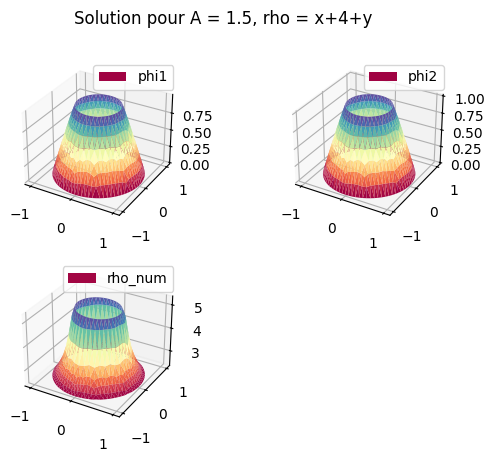

norme L2 rho_num_H1 -rho_exact 0.018670569863704373
norme L2 phi1_H1 - phi_exact 3.0092121256188573e-06
norme L2 phi2_H1 - phi_exact 3.328782665866193e-06


In [14]:
import matplotlib.pyplot as plt
from ngsolve import *
import ngsolve
import math
import matplotlib.tri as mtri


def rho(x,λ,r_0):
    if λ >=-1:
        return λ/((f(λ,r_0,1)-f(λ,r_0,r_0))*sqrt(λ*x**2+1))
    elif λ <= -1/r_0**2:
        return  -λ/((f(λ,r_0,1)-f(λ,r_0,r_0))*sqrt(-λ*x**2-1))

def f(λ,r_0,x):
    if λ >=-1:
        return sqrt(1+λ*x**2)- log(sqrt(1+λ*x**2)+1)+log(x)
    if λ <= -1/r_0**2:
        return sqrt(-λ*x**2-1)-atan(sqrt(-λ*x**2-1))

def A_lambda(λ):
    return math.sqrt(abs(λ+1/r_0**2))/ (f(λ,r_0,1)-f(λ,r_0,r_0))


def ϕ(λ,r_0,x):
    return (f(λ,r_0,1)-f(λ,r_0,x))/(f(λ,r_0,1)-f(λ,r_0,r_0))

#Définition de l'espace 
r_0 = 0.5
λ = -10

#espace = Demi_disque((0,-1), 2.0,0.5,(-3,-3),(2,-1))
#espace = Square(0.3,(-1,-1),(1,1))
espace = Anneau(0.5, 1.0)
maillage = Maillage(0.08, espace)

deriv_normal = maillage.get_derive_normal()[1] 
fes = H1(maillage.mesh, order = 1)


ρ_exact = GridFunction(fes)
ρ_exact.Set(rho(sqrt(x**2+y**2),λ,r_0))

phi_exact = GridFunction(fes)
phi_exact.Set(ϕ(λ,r_0,sqrt(x**2+y**2)))

val_A = GridFunction(fes)
val_A.Set(A_lambda(λ))


p_H1 = Problem_2D(maillage,val_A)


print("p_H1",p_H1.is_lower())


ρ_grid = GridFunction(fes)
ρ_grid.Set(x+y +4) 
ρ_array = np.array(ρ_grid.vec)
ρ_init = ρ_array


res_H1 = p_H1.minimize(ρ_array)
print("H1",res_H1.nit, res_H1.success, res_H1.status, res_H1.message)
ρ_sol_grid_H1 = maillage.discret_to_grid(res_H1.x, True)
phi1_H1 = p_H1.solve_phi1(ρ_sol_grid_H1)
phi2_H1 = p_H1.solve_phi2(ρ_sol_grid_H1)


def lower(f : GridFunction, a : int):
    """f<=a"""
    list = []
    flag = True
    for i in range(f.vec.size):
        if f.vec[i] -a>10e-10:
            flag = False
            list.append(f.vec[i])
    print(list)
    return flag

def upper(f : GridFunction, a : int):
    """f >a"""
    flag = True
    list = []
    for i in range(f.vec.size):
        if f.vec[i] <=a:
            flag = False
            list.append(f.vec[i])
    return flag


print('phi1_H1<=1' , lower(phi1_H1,1))



triangles = []

for el in maillage.mesh.Elements(VOL): #prend tous les triangles?
    v = el.vertices
    triangles.append([v[0].nr, v[1].nr, v[2].nr])


fig = plt.figure()
ax = fig.add_subplot(2,2,1,projection ='3d')

X = np.array([v.point[0] for v in maillage.mesh.vertices])
Y = np.array([v.point[1] for v in maillage.mesh.vertices])
#phi_exact = GridFunction(fes)
#phi_exact.Set(ϕ(λ,r_0,sqrt(x**2+y**2)))
#rho_triang = rho(sqrt(X**2+Y**2),λ,r_0)

triang = mtri.Triangulation(X,Y,triangles = triangles)
#ax.plot_trisurf(triang, rho_triang , label = "rho_init", cmap = plt.cm.Spectral)
ax.plot_trisurf(triang, np.array(phi1_H1.vec), label = "phi1", cmap = plt.cm.Spectral)
ax.legend()


ax = fig.add_subplot(2,2,2, projection = '3d')

ax.plot_trisurf(triang, np.array(phi2_H1.vec), label = "phi2", cmap = plt.cm.Spectral)
ax.legend()

ax = fig.add_subplot(2,2,3, projection = '3d')

ax.plot_trisurf(triang, np.array(res_H1.x), label = "rho_num", cmap = plt.cm.Spectral)
ax.legend()



#soustract_phi = GridFunction(fes)
#soustract_phi.Set(phi1-phi2)

fig.suptitle("Solution pour A = 1.5, rho = x+4+y")

plt.show()


soustract_rho_H1 = GridFunction(fes)
soustract_rho_H1.Set(ρ_sol_grid_H1 - ρ_exact)
print("norme L2 rho_num_H1 -rho_exact", maillage.norme_L2_carre(soustract_rho_H1))


soustract_phi1_H1 = GridFunction(fes)
soustract_phi1_H1.Set(phi1_H1- phi_exact)
print("norme L2 phi1_H1 - phi_exact", maillage.norme_L2_carre(soustract_phi1_H1))


soustract_phi2_H1 = GridFunction(fes)
soustract_phi2_H1.Set(phi2_H1- phi_exact)
print("norme L2 phi2_H1 - phi_exact", maillage.norme_L2_carre(soustract_phi2_H1))
#print("norme L2 phi1-phi2", maillage.norme_L2_carre(soustract_phi))
